In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, r2_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier


In [196]:
df = pd.read_csv('Churn_Modelling.csv')

In [197]:
pd.set_option('display.max_columns', None) #show all columns 
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [199]:
df.Exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

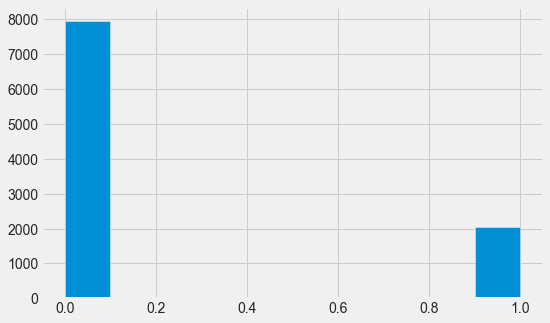

In [201]:
# Target distribution
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8,5]

plt.hist(df.Exited)
plt.show()

In [202]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [203]:
df.dtypes.value_counts()

int64      9
object     3
float64    2
dtype: int64

In [204]:
# variability of objects features
df.select_dtypes(include=[object]).apply(pd.Series.nunique, axis = 0)


Surname      2932
Geography       3
Gender          2
dtype: int64

In [207]:
# Remove the column with names then expand the categorical columns
df = df.drop(['Surname','CustomerId','HasCrCard'], axis=1)
df_dummies = pd.get_dummies(df)

In [208]:
df.shape, df_dummies.shape

((10000, 11), (10000, 14))

In [209]:
df_dummies.head()

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,1,101348.88,1,1,0,0,1,0
1,2,608,41,1,83807.86,1,1,112542.58,0,0,0,1,1,0
2,3,502,42,8,159660.80,3,0,113931.57,1,1,0,0,1,0
3,4,699,39,1,0.00,2,0,93826.63,0,1,0,0,1,0
4,5,850,43,2,125510.82,1,1,79084.10,0,0,0,1,1,0


In [210]:
# Correlation with the target variable
correlations = df_dummies.corr()['Exited'].sort_values()

In [211]:
correlations

IsActiveMember      -0.156128
Gender_Male         -0.106512
Geography_France    -0.104955
Geography_Spain     -0.052667
NumOfProducts       -0.047820
CreditScore         -0.027094
RowNumber           -0.016571
Tenure              -0.014001
EstimatedSalary      0.012097
Gender_Female        0.106512
Balance              0.118533
Geography_Germany    0.173488
Age                  0.285323
Exited               1.000000
Name: Exited, dtype: float64

Text(0, 0.5, 'Count')

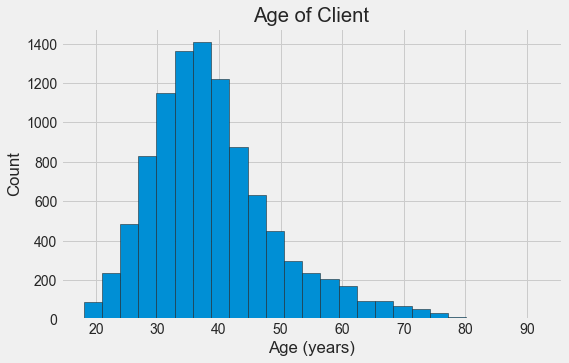

In [212]:
plt.hist(df_dummies['Age'], edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

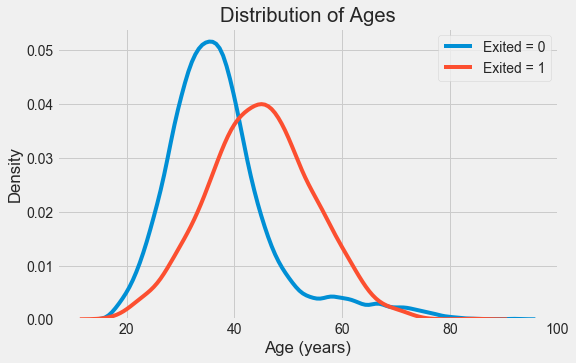

In [213]:
# Density of exited by age
sns.kdeplot(df_dummies.loc[df_dummies['Exited'] == 0, 'Age'] , label = 'Exited = 0')

sns.kdeplot(df_dummies.loc[df_dummies['Exited'] == 1, 'Age'] , label = 'Exited = 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [215]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = df_dummies[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Total amount': temp.values})

    # Calculation of the share of exited by category
    cat_perc = df_dummies[[feature, 'Exited']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='Exited', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Total amount",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='Exited', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percentage of Exited', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

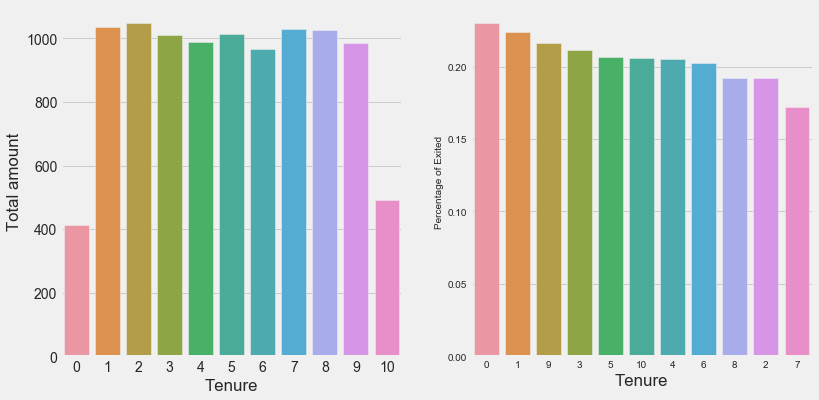

In [216]:
plot_stats('Tenure')

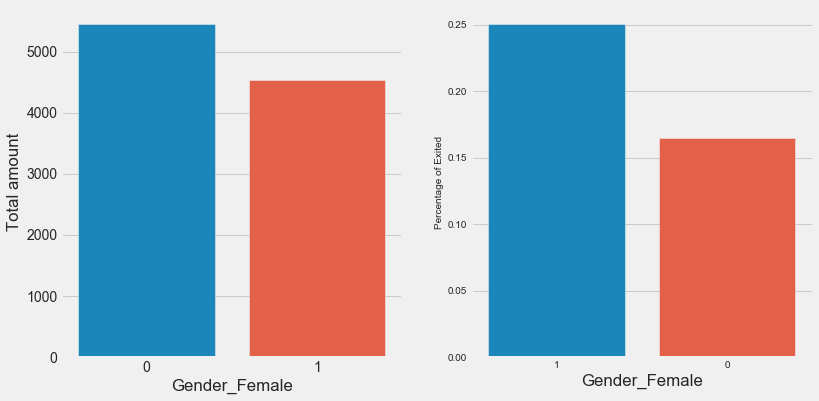

In [217]:
plot_stats('Gender_Female')

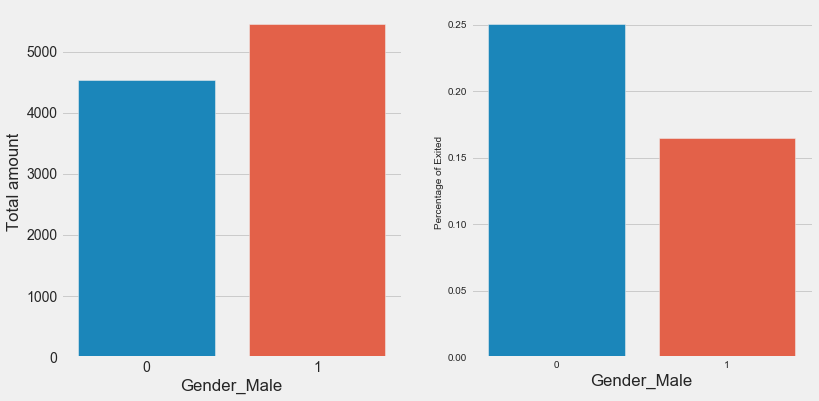

In [220]:
plot_stats('Gender_Male')

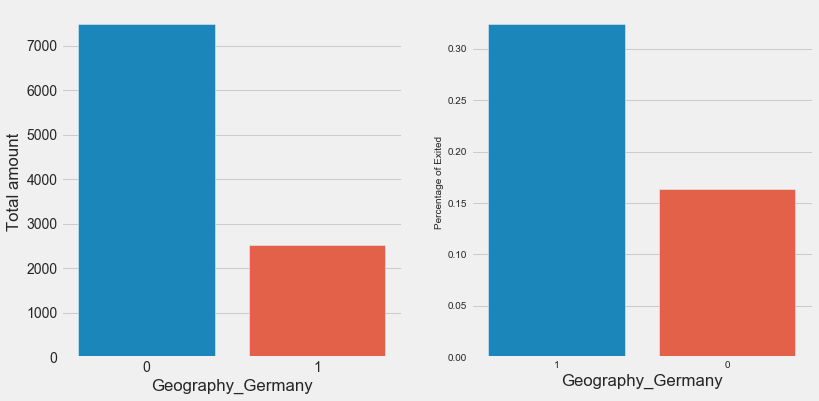

In [219]:
plot_stats('Geography_Germany')

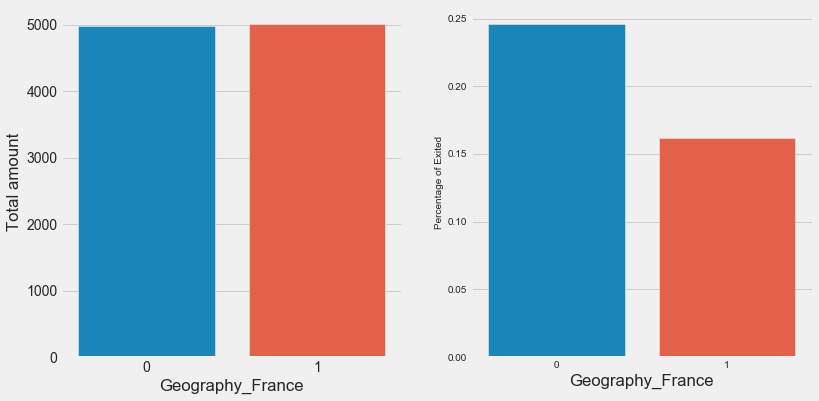

In [221]:
plot_stats('Geography_France')

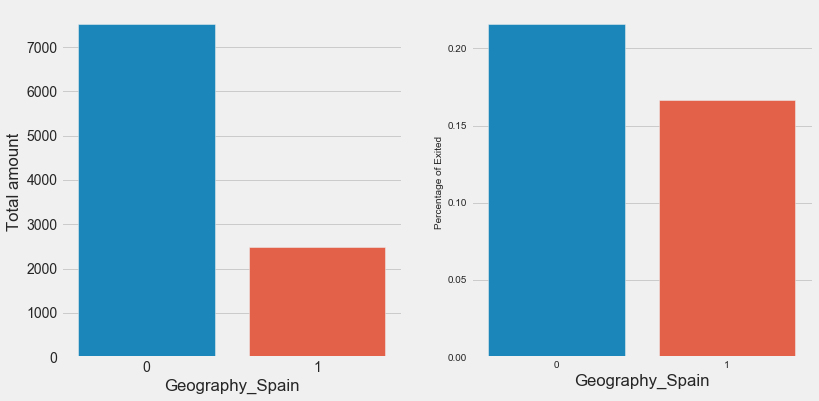

In [222]:
plot_stats('Geography_Spain')

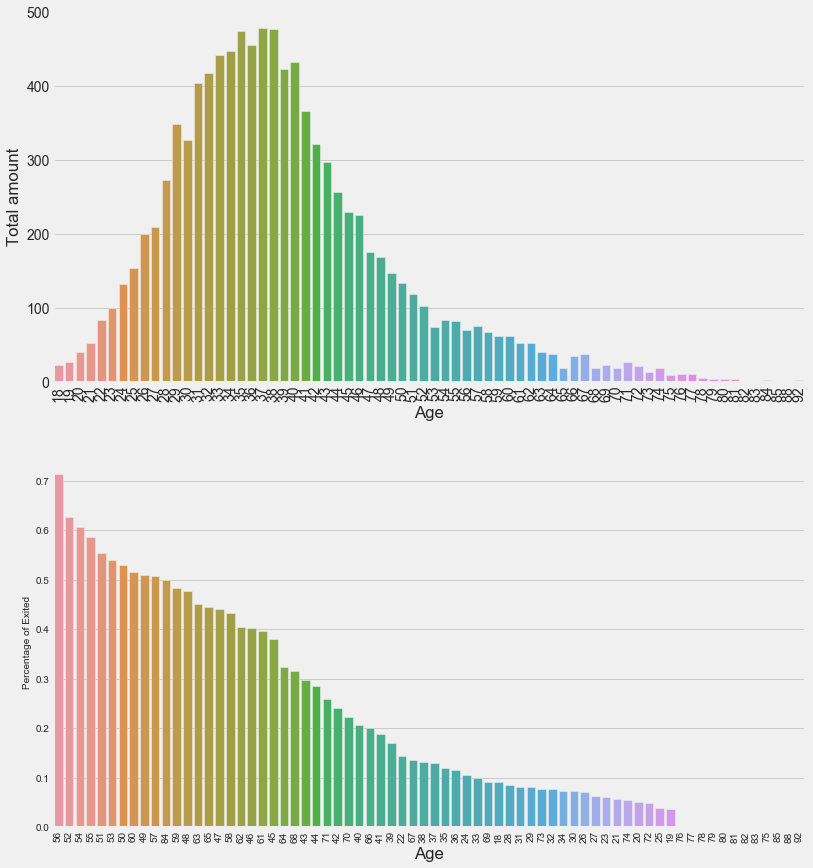

In [223]:
plot_stats('Age',True, False)

In [224]:
X = df_dummies.drop(['Exited'],axis=1)
y = df_dummies.Exited

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

At this stage, let's start right away with using Random Forest and Gradient Boosting.

In [226]:
clf_rf = RandomForestClassifier(random_state=42)

In [227]:
clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [72]:
clf_rf.score(X_train,y_train)

1.0

In [73]:
clf_rf.score(X_test,y_test)

0.868

In [74]:
clf_rf1 = RandomForestClassifier(random_state=0)
parametrs = {'n_estimators': list(range(10,51,5)), 
             'max_depth':list(range(1,13)), 
             'min_samples_leaf': list(range(1,8)),
            'min_samples_split': list(range(2,9))}
grid_search_clf_rf = GridSearchCV(clf_rf1, parametrs, cv=5, n_jobs=-1)

In [75]:
grid_search_clf_rf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [76]:
grid_search_clf_rf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 40}

In [77]:
best_clf_rf = grid_search_clf_rf.best_estimator_

In [159]:
best_clf_rf.score(X_test,y_test)

0.8705

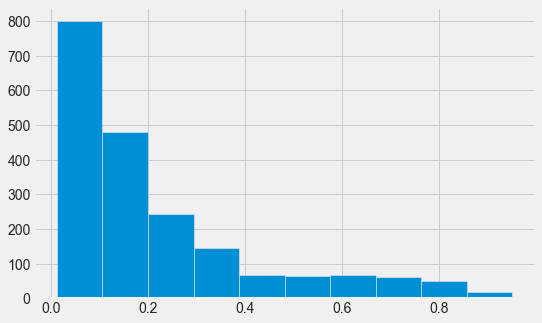

In [229]:
y_predicted_prob = best_clf_rf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

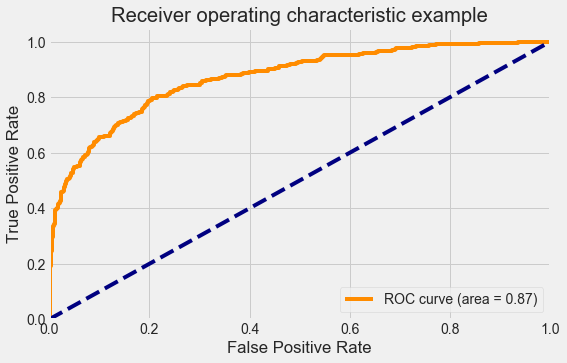

In [230]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [110]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...ight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                         'gamma': [0.0, 0.1, 0.

In [116]:
grid_best = grid.best_estimator_

In [121]:
grid.best_params_

{'colsample_bytree': 0.7,
 'eta': 0.05,
 'gamma': 0.2,
 'max_depth': 4,
 'min_child_weight': 1}

In [144]:
grid_best.score(X_train,y_train)

0.879625

In [145]:
grid_best.score(X_test,y_test)

0.8695

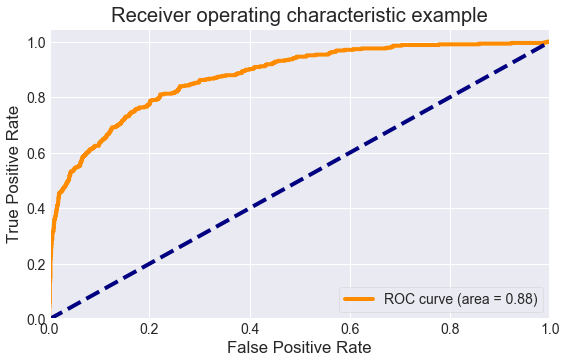

In [142]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ROC AUC = 88

Let's try other models

In [149]:
r_state = 3
classifier_DTC = DecisionTreeClassifier(random_state = r_state)
classifier_DTC.fit(X_train, y_train)

y_pred_DTC = classifier_DTC.predict(X_test)
accuracy_score(y_test, y_pred_DTC)

0.8015

In [152]:
classifier_SVC = SVC(random_state = r_state)
classifier_SVC.fit(X_train, y_train)

y_pred_SVC = classifier_SVC.predict(X_test)
accuracy_score(y_test, y_pred_SVC)

0.7975

In [154]:
classifier_ABC = AdaBoostClassifier(learning_rate = 0.01,
                                   random_state = r_state) # Default using Decision Tree Classifier
classifier_ABC.fit(X_train, y_train)

y_pred_ABC = classifier_ABC.predict(X_test)
accuracy_score(y_test, y_pred_ABC)

0.814

In [155]:
classifier_RFC = RandomForestClassifier(random_state = r_state)
classifier_RFC.fit(X_train, y_train)

y_pred_RFC = classifier_RFC.predict(X_test)
accuracy_score(y_test, y_pred_RFC)

0.863

In [156]:
classifier_ABC_RF = AdaBoostClassifier(RandomForestClassifier(random_state = r_state),
                                       learning_rate = 0.01,
                                       random_state = r_state) 
classifier_ABC_RF.fit(X_train, y_train)

y_pred_ABC_RF = classifier_ABC_RF.predict(X_test)
accuracy_score(y_test, y_pred_ABC_RF)

0.8635

In [158]:
classifier_GBC = GradientBoostingClassifier(random_state = r_state)
classifier_GBC.fit(X_train, y_train)

y_pred_GBC = classifier_GBC.predict(X_test)
accuracy_score(y_test, y_pred_GBC)

0.87

In [161]:
classifier_KNN = KNeighborsClassifier(n_neighbors = 5)
classifier_KNN.fit(X_train, y_train)

y_pred_KNN = classifier_KNN.predict(X_test)
accuracy_score(y_test, y_pred_KNN)

0.7575

In [164]:
classifier_XGB = XGBClassifier()
classifier_XGB.fit(X_train, y_train)

y_pred_XGB = classifier_XGB.predict(X_test)
accuracy_score(y_test, y_pred_XGB)

0.8665

In [168]:
classifiers = [classifier_DTC,
               classifier_SVC,
               classifier_ABC, 
               classifier_RFC, 
               classifier_ABC_RF, 
               classifier_GBC, 
               classifier_KNN, 
               classifier_XGB]
classifiers_names = ['Decision Tree',
                     'SVC', 
                     'AdaBoost',
                     'Random Forest',
                     'AdaBoost - Random Forest',
                     'Gradient Boosting',
                     'KNeighborsClassifier',
                     'XG Boost']
accuracy_mean = []

for cl in classifiers :
    accuracies = cross_val_score(estimator = cl, 
                                 X = X_train, 
                                 y = y_train, 
                                 cv = 4)
    accuracy_mean.append(accuracies.mean()*100)

    
accuracy_df = pd.DataFrame({'Classifier': classifiers_names,
                           'Accuracy Mean': accuracy_mean})
accuracy_df.sort_values('Accuracy Mean',ascending=False)

,Classifier,Accuracy Mean
5,Gradient Boosting,86.2625
7,XG Boost,86.2625
3,Random Forest,86.0750
4,AdaBoost - Random Forest,85.8000
2,AdaBoost,81.1250
1,SVC,79.6000
0,Decision Tree,77.9625
6,KNeighborsClassifier,75.9000


In [ ]:
voting_cl = VotingClassifier(estimators = [('Gradient Boosting', classifier_GBC),
                                              ('Decision Tree',classifier_RFC),
                                              ('XG Boost',classifier_DTC)], 
                                voting = 'hard')
voting_cl.fit(X_train, y_train)
y_pred_vcl = voting_cl.predict(X_test)
accuracy_score(y_test, y_pred_vcl)

In [171]:
gb_params = [{'loss': ['deviance', 'exponential'], 
              'learning_rate': [0.1, 0.01, 0.001],
              'n_estimators': [100, 250, 500]}]
grid_search_GBC = GridSearchCV(estimator = classifier_GBC,
                               param_grid = gb_params,
                               scoring = 'accuracy',
                               cv = 4,
                               n_jobs = -1)
grid_search_GBC.fit(X_train, y_train)
best_accuracy_GBC = grid_search_GBC.best_score_
best_parameters_GBC = grid_search_GBC.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy_GBC*100))
print("Best Parameters:", best_parameters_GBC)

Best Accuracy: 86.26 %
Best Parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 100}


In [175]:
best_clf_GBC = grid_search_GBC.best_estimator_

In [176]:
best_clf_GBC.score(X_test,y_test)

0.87

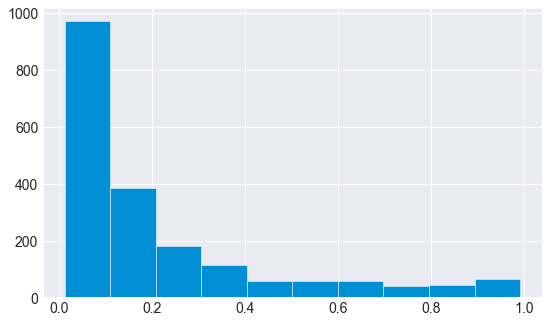

In [180]:
y_predicted_prob = best_clf_GBC.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

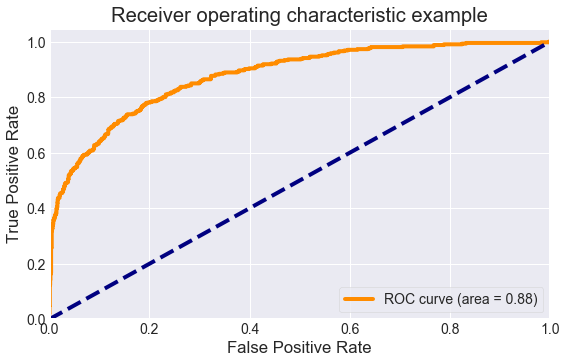

In [181]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The best result shows gradient boosting  (ROC AUC = 0.88) at accuracy 0.87